In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score

nltk.download('punkt')
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Путь к файлу CSV
data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv"
train_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv"
test_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv"

# Чтение данных из CSV-файлов
data = pd.read_csv(data_path)
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
data = data.rename(columns={'atis_flight': 'intent', ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning': 'text'})
lost_intent = {'intent': 'atis_flight', 'text': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning'}
data = pd.concat([data, pd.DataFrame([lost_intent])], ignore_index=True)

In [5]:
# Find classes with only one sample
class_counts = data['intent'].value_counts()
single_sample_classes = class_counts[class_counts == 1].index.tolist()

# Separate single sample classes
single_sample_data = data[data['intent'].isin(single_sample_classes)]
multiple_sample_data = data[~data['intent'].isin(single_sample_classes)]

In [6]:
train_multiple, test_multiple = train_test_split(multiple_sample_data, test_size=0.2, random_state=42, stratify=multiple_sample_data['intent'])

# Add single sample data to both train and test sets to ensure all classes are present
train = pd.concat([train_multiple, single_sample_data]).reset_index(drop=True)
test = pd.concat([test_multiple, single_sample_data]).reset_index(drop=True)

# Ensure no duplicates in train and test sets
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [7]:
# Check for missing classes and ensure all classes are present
train_classes = set(train['intent'])
test_classes = set(test['intent'])
all_classes = set(data['intent'])

# Find missing classes in train and test sets
missing_train_classes = all_classes - train_classes
missing_test_classes = all_classes - test_classes

# Add missing classes examples to train and test sets
if missing_train_classes:
    missing_train_data = data[data['intent'].isin(missing_train_classes)]
    train = pd.concat([train, missing_train_data])
    train = train.drop_duplicates().reset_index(drop=True)

if missing_test_classes:
    missing_test_data = data[data['intent'].isin(missing_test_classes)]
    test = pd.concat([test, missing_test_data])
    test = test.drop_duplicates().reset_index(drop=True)

# Print unique value proportions
unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
print(unique_values_normalized * 100, len(unique_values_normalized), len(unique_values_normalized_test)) 

intent
atis_flight                                 73.869079
atis_airfare                                 8.621607
atis_ground_service                          5.082491
atis_airline                                 3.113358
atis_abbreviation                            2.474721
atis_aircraft                                1.676424
atis_flight_time                             1.117616
atis_quantity                                1.091006
atis_distance                                0.425758
atis_flight#atis_airfare                     0.399148
atis_ground_fare                             0.372539
atis_airport                                 0.372539
atis_city                                    0.372539
atis_capacity                                0.345929
atis_flight_no                               0.266099
atis_meal                                    0.133049
atis_restriction                             0.106440
atis_airline#atis_flight_no                  0.053220
atis_ground_service#a

In [8]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import timeit

In [10]:
# Создание пайплайна
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: tokenizer.encode(x, add_special_tokens=True))),
    ('DecisionTree', DecisionTreeClassifier(max_depth=50)) 
])

# Обучение пайплайна
pipeline.fit(train['text'], train['intent'])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7ad10c8cf2e0>)),
                ('DecisionTree', DecisionTreeClassifier(max_depth=50))])

In [11]:
start_test = timeit.default_timer()
# Прогноз на тестовом наборе
predictions = pipeline.predict(test['text'])
end_test = timeit.default_timer()

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')

print(balanced_accuracy_score(test['intent'], predictions))
print(precision_recall_fscore_support(test['intent'], predictions, average='weighted'))

Time for testing: 0.5935 seconds
Average time per response: 0.000606 seconds
0.7693445543170508
(0.9342836722546835, 0.926530612244898, 0.9277340282048692, None)


In [12]:
def plotCM(test, predictions, name:'str'):
    # Построение confusion matrix
    labels = test['intent'].unique()  # получите уникальные метки классов
    cm = confusion_matrix(test['intent'], predictions, labels=labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'{name}')
    plt.show()

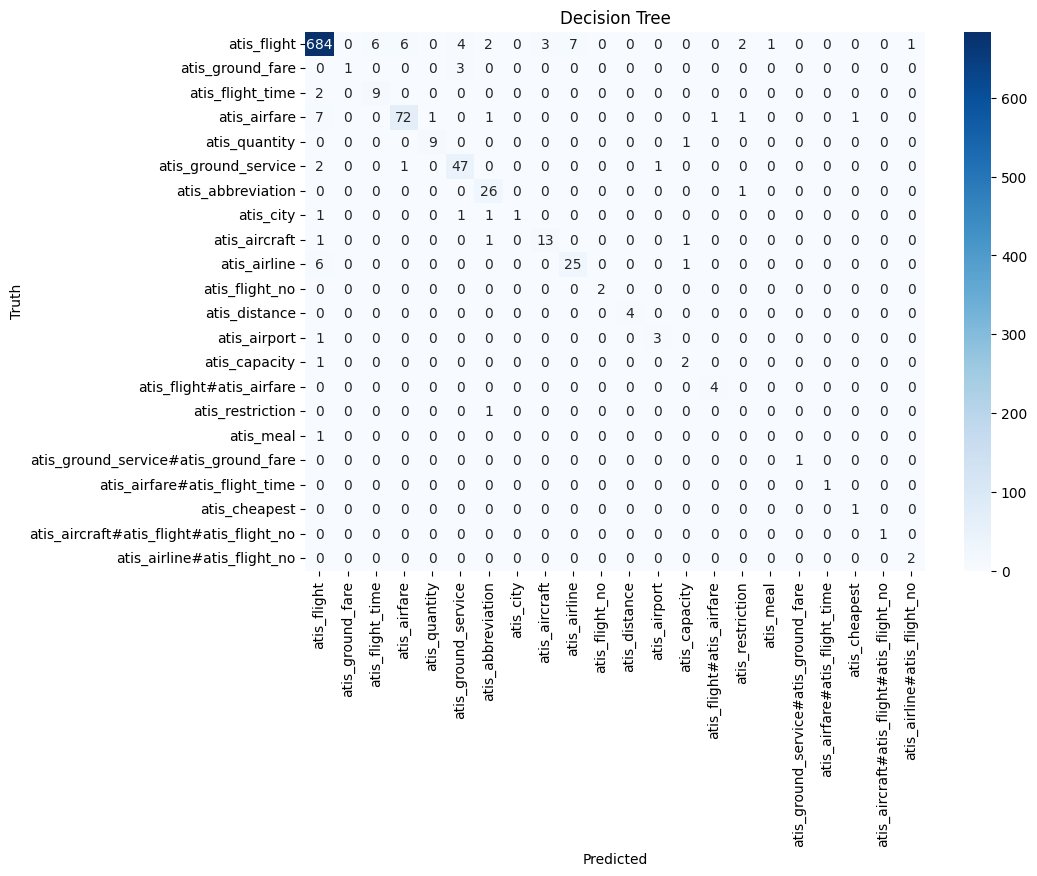

In [13]:
plotCM(test, predictions, 'Decision Tree')

Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
# Создание пайплайна
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: tokenizer.encode(x, add_special_tokens=True))),
    ('RandomForest', RandomForestClassifier(max_depth=50, n_estimators=30)) 
])

# Обучение пайплайна
pipeline.fit(train['text'], train['intent'])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7ad105c3eb90>)),
                ('RandomForest',
                 RandomForestClassifier(max_depth=50, n_estimators=30))])

In [16]:
start_test = timeit.default_timer()

# Прогноз на тестовом наборе
predictions_forest = pipeline.predict(test['text'])
end_test = timeit.default_timer()

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')

Time for testing: 0.6122 seconds
Average time per response: 0.000625 seconds


In [17]:
print(balanced_accuracy_score(test['intent'], predictions_forest))
print(precision_recall_fscore_support(test['intent'], predictions_forest, average='weighted'))

0.681616688413211
(0.9426873204905235, 0.9448979591836735, 0.9370262176960087, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


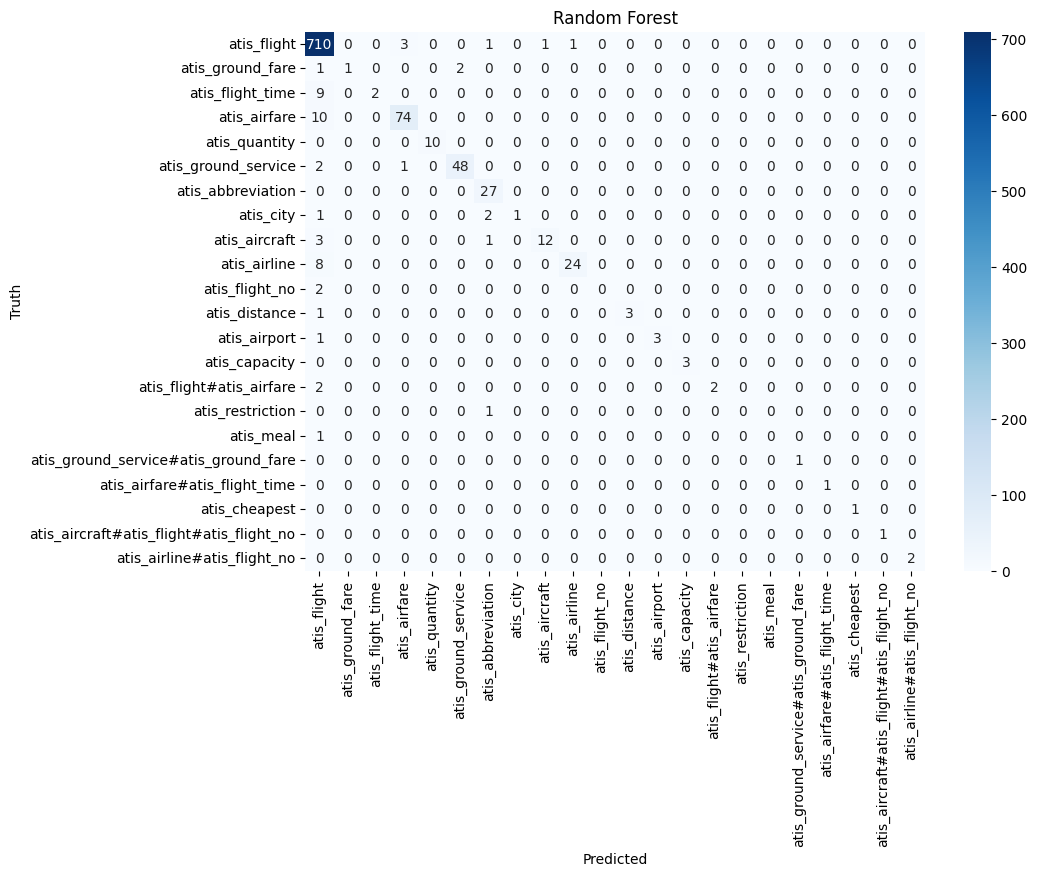

In [18]:
plotCM(test, predictions_forest, 'Random Forest')

AdaBoost + TF-IDF


In [19]:
from sklearn.ensemble import AdaBoostClassifier

In [20]:
# Создание пайплайна
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))),
    ('AdaBoost', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=80), n_estimators=50, learning_rate=1.0, random_state=42)) 
])

# Преобразование меток в числовые значения
le = LabelEncoder()
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])

# Обучение пайплайна
pipeline.fit(train['text'], train_labels)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7ad10cb90c10>)),
                ('AdaBoost',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=80),
                                    random_state=42))])

In [21]:
start_test = timeit.default_timer()
# Прогноз на тестовом наборе
predictions = pipeline.predict(test['text'])
end_test = timeit.default_timer()
# Перевод меток обратно в исходные интенты
predictions_AdaBoost = le.inverse_transform(predictions)


# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
# Вывод метрик оценки качества модели
print(balanced_accuracy_score(test_labels, predictions))
print(precision_recall_fscore_support(test_labels, predictions, average='weighted'))

Time for testing: 0.6195 seconds
Average time per response: 0.000632 seconds
0.7739955763202111
(0.9283796041850753, 0.9204081632653062, 0.9225999440137751, None)


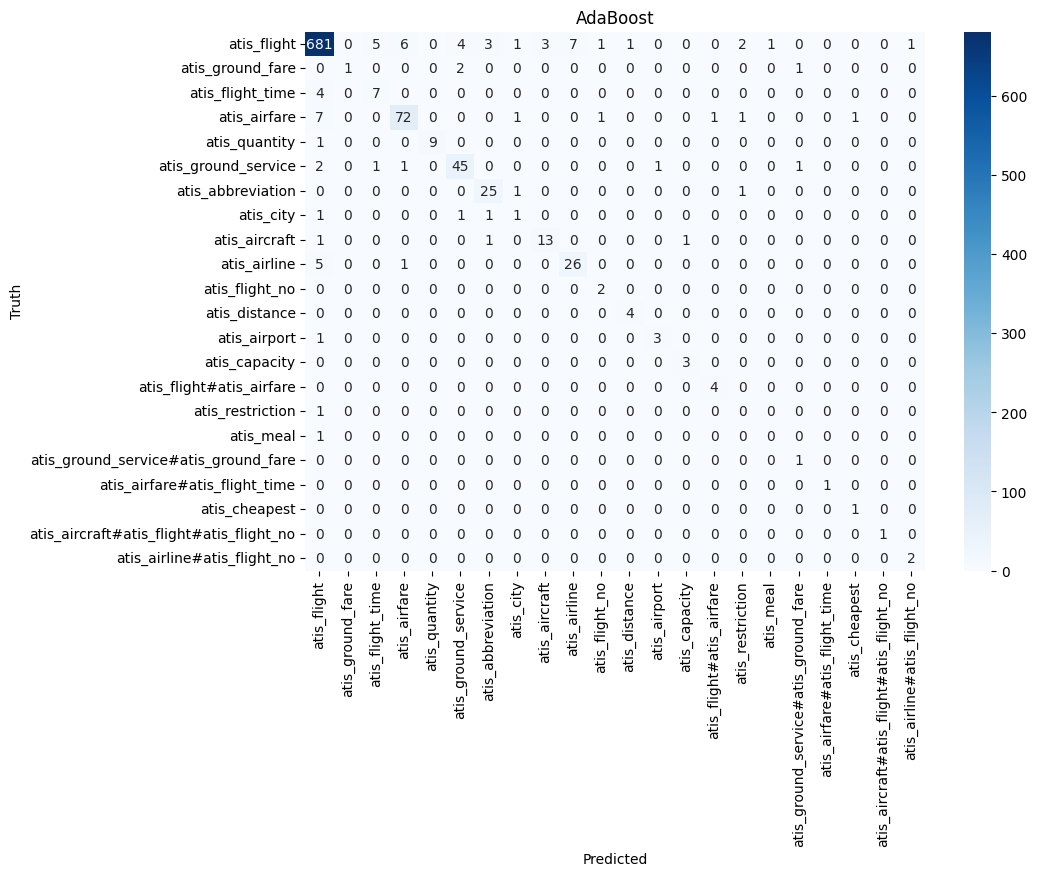

In [22]:
plotCM(test, predictions_AdaBoost, 'AdaBoost')

AdaBoost + M-USE

In [23]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
import timeit

In [24]:
# Загрузка модели и токенизатора
tokenizer = AutoTokenizer.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")
model = AutoModel.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")

# Токенизация и кодирование текстовых данных
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [25]:
# Определение собственного Dataset для PyTorch
class TextDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [26]:
# Извлечение эмбеддингов
with torch.no_grad():
    train_embeddings = model(**train_encodings).last_hidden_state.mean(dim=1)
    test_embeddings = model(**test_encodings).last_hidden_state.mean(dim=1)

# Преобразование меток в числовые значения
le = LabelEncoder()
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])


# Создание DataLoader-ов
train_dataset = TextDataset(train_embeddings, torch.tensor(train_labels))
test_dataset = TextDataset(test_embeddings, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [27]:
# Создание и обучение модели
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=50), n_estimators=50, learning_rate=1.0, random_state=42)
model.fit(train_embeddings.numpy(), train_labels)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=50),
                   random_state=42)

In [28]:
start_test = timeit.default_timer()
# Прогноз на тестовом наборе
predictions = model.predict(test_embeddings.numpy())
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
# Вывод метрик оценки качества модели
print(balanced_accuracy_score(test_labels, predictions))
print(precision_recall_fscore_support(test_labels, predictions, average='weighted'))

Time for testing: 0.0024 seconds
Average time per response: 0.000002 seconds
0.4364185534022978
(0.7590323730122011, 0.7153061224489796, 0.733747957483049, None)
